# Generative Forecast Autoregressively (with MoE)
### **NOTE: this notebook assumes that all experts are have identical model architecture**

* This notebook loads a pre-trained time series model to make forecast with minimal testing data. 

* Model takes previous lags to autoregressively make forecast. Last forecast is appended to initial data.
    * This can be repeted with indefinately but forecasts are less accurate as steps increase.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader, random_split

from models.transformer import GPTTimeSeries

import os
import random
import numpy as np
import pandas as pd
import math
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from collections.abc import Iterable

plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'USING DEVICE: {device}')

USING DEVICE: cuda


# Load Saved Checkpoint

In [2]:
checkpoint = torch.load('./saved_models/GPTTimeSeries_Autoregressive_MoE.pt')
checkpoint.keys()

C:\Users\hfuat\AppData\Local\Temp\ipykernel_40264\936429453.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('./saved_models/GPTTimeSeries_Autoreg

dict_keys(['expert_0', 'expert_1'])

In [3]:
# NOTE: this assumes that all experts are have identical model architecture
hyperparameters = checkpoint['expert_0']['hyperparameters']

# Load Saved (Pre-trained) Model

In [4]:
print('Model hyperparameters is loaded with:')

for k, v in hyperparameters.items():
    print(f'{k:<25} {v}')
print()

Model hyperparameters is loaded with:
seed                      1234
window_size               20
batch_size                128
split_ratio               0.8
learning_rate             0.001
num_epochs                50
use_amp                   False
num_experts               2



# Seed

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
seed_everything(hyperparameters['seed'])

# List of Datasets
* Each expert in MoE gets a different dataset in this case

In [6]:
dataset_names = [
    #'NAB/data/realTweets/Twitter_volume_AAPL.csv',
    #'NAB/data/realTweets/Twitter_volume_AMZN.csv',
    'NAB/data/realAWSCloudwatch/ec2_cpu_utilization_24ae8d.csv',
    'NAB/data/realAWSCloudwatch/ec2_cpu_utilization_53ea38.csv',
]

# Dataset

In [7]:
class MixtureTimeSeriesDataset(Dataset):
    def __init__(self, data_path_list, window_size, feature_columns, datetime_column):
        """
        data_path_list: required to be a .csv file
        feature_columns and datetime_column: can be a single string (same for all datasets) or iterable strings (different per dataset).
        feature_columns should be 2D iterable of feature columns for each dataset. If a single string or iterable is given, it will be copied for all datasets
        datetime_column should be 1D iteralbe of datetime columns for each dataset. If a single string is given, it will be copied for all datasets
        """
        
        self.data_path_list = data_path_list
        self.window_size = window_size

        self.named_df_list = {}

        self.df_list = []
        self.scalers = []

        # utility function used in read_and_scale() 
        self.check_if_series = lambda x: pd.DataFrame(x) if isinstance(x, pd.Series) else x

        # If feature_columns is a single string of single feature
        if isinstance(feature_columns, str):
            self.feature_columns = [[feature_columns] for _ in range(len(data_path_list))]
        # Check if inner dimension is iterable
        # (feature_columns expected to be a 2D/1D iterable or single string)
        elif isinstance(feature_columns[0], Iterable):
            if len(feature_columns) != len(data_path_list):
                raise ValueError('feature_columns should be 2D/1D iterable of feature columns or a singe string.')
            self.feature_columns = feature_columns
        # If feature_columns contains mutiple features (1D iterable)
        elif isinstance(feature_columns, Iterable):
            self.feature_columns = [feature_columns for _ in range(len(data_path_list))]
        else:
            raise ValueError('unrecognized feature_columns format!')

        # If feature_columns is a single string of single feature
        if isinstance(datetime_column, str):
            self.datetime_column = [datetime_column for _ in range(len(data_path_list))]
        # (datetime_column expected to be a 1D iterable or single string)
        elif isinstance(datetime_column, Iterable):
            if len(datetime_column) != len(data_path_list):
                raise ValueError('datetime_column should be 1D iterable of datetime columns or a singe string.')
            self.datetime_column = datetime_column
        else:
            raise ValueError('unrecognized datetime_column format!')

        self.read_and_scale()
    
    def __len__(self):
        len_list = [_df.shape[0] for _df in self.df_list]
        # take the longest as referance len
        number_of_samples = max(len_list)
        # make sure that last window fits
        return number_of_samples #- self.window_size

    def read_csv_with_datetime_index(self, data_path, datetime_column='timestamp'):
        _df = pd.read_csv(data_path)
        _df[datetime_column] = pd.to_datetime(_df[datetime_column])
        _df.set_index(datetime_column, inplace=True)
        return _df
    
    def read_and_scale(self):
        """
        read and standard scales each .csv file
        """
        
        for path, _feature_columns, _datetime_column in zip(self.data_path_list, self.feature_columns, self.datetime_column):
            _df = self.read_csv_with_datetime_index(path, _datetime_column)
            
            _scaler = StandardScaler()
            print('>>>', _df.columns)
            if _df[_feature_columns].values.ndim < 2:
                _df[_feature_columns] = _scaler.fit_transform(_df[_feature_columns].values.reshape(-1, 1)).reshape(-1)
            else:
                _df[_feature_columns] = _scaler.fit_transform(_df[_feature_columns])
            _df = _df[_feature_columns]
            
            self.df_list.append(_df)
            self.scalers.append(_scaler)

        self.named_df_list = {f'expert_{i}': self.check_if_series(_df) for i, _df in enumerate(self.df_list)}
        #for ___df in self.named_df_list.values():
        #    print(type(___df))
    
    def add_padding_maybe(self, _df_window):
        _df_window = _df_window.copy()
        if _df_window.shape[0] < self.window_size:
            num_rows_to_add = self.window_size - _df_window.shape[0]
            pad_date = pd.Timestamp('1970-01-01')
            pad_date_indexes = [pad_date] * num_rows_to_add
            df_zeros = pd.DataFrame(0.0, index=pad_date_indexes, columns=_df_window.columns)
            _df_window['attention_mask'] = 1.0
            df_zeros['attention_mask'] = 0.0
            df_padded = pd.concat([_df_window, df_zeros])
            return df_padded
        else:
            _df_window['attention_mask'] = 1.0
            return _df_window
        
    def __getitem__(self, start_idx):
        return_dict = {}

        for name, df_expert in self.named_df_list.items():
                    
            # get a NumPy array of size: (hyperparameters['window_size'], NUM_FEATURES)
            df_window = df_expert.iloc[start_idx:start_idx+self.window_size]
    
            # apend padding values (zeros) if necessery
            df_window = self.add_padding_maybe(df_window)
        
            # attention mask
            # 1 -> regular values, 0 -> pad values
            # (0s supposed to be masked)
            attention_mask = df_window['attention_mask'].copy()
            df_window.drop('attention_mask', axis=1, inplace=True)
            # (window_size, ) -> (lags/forecast,)
            attention_mask = attention_mask[:-1].values
            
            sample_window = df_window.values
            # input (lag) timestamps
            sample_timestamp_lags = df_window[:-1].index
            
            # divide window into lags and forecast (shifted by 1)
            # first window_size-1 steps
            lags = sample_window[:-1, :]
            # last window_size-1 steps
            forecast = sample_window[1:, :]
            
            # convert to tensor
            lags = torch.tensor(lags, dtype=torch.float32)
            forecast = torch.tensor(forecast, dtype=torch.float32)
            
            # (lags, date_input_features_size)
            # 1970-01-01 is used for padding values
            date = torch.tensor([sample_timestamp_lags.month, sample_timestamp_lags.day, sample_timestamp_lags.hour], dtype=torch.float32).permute(1, 0)

            # attention mask (tensor)
            attention_mask = torch.tensor(attention_mask, dtype=torch.float32)
            
            return_dict[name] = (lags, forecast, date, attention_mask)
        
        return return_dict

In [8]:
dataset_full = MixtureTimeSeriesDataset(
    data_path_list=dataset_names,
    window_size=120,
    feature_columns=['value', 'value'],
    datetime_column=['timestamp', 'timestamp'],
)
print(len(dataset_full))

dataset_full.named_df_list.keys()

>>> Index(['value'], dtype='object')
>>> Index(['value'], dtype='object')
4032


dict_keys(['expert_0', 'expert_1'])

<Axes: xlabel='timestamp'>

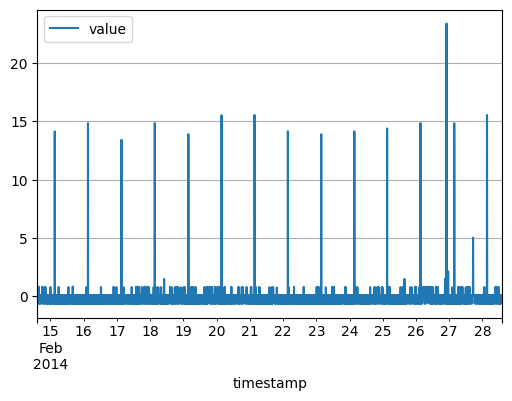

In [9]:
dataset_full.named_df_list['expert_0'].plot()

<Axes: xlabel='timestamp'>

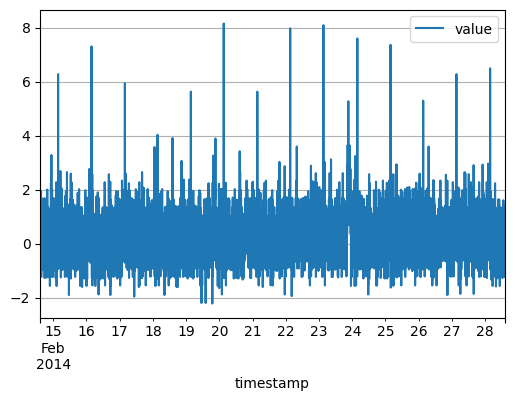

In [10]:
dataset_full.named_df_list['expert_1'].plot()

In [11]:
_return_dict = dataset_full[4000]
_return_dict.keys()

dict_keys(['expert_0', 'expert_1'])

# Time series data shape: 
Unbatched: $(S, F)$

* $S:$ Sequence Length
* $F:$ Number of Features

Batched: $(B, S, F)$
* $B:$ Batch Size

In [12]:
_lags, _forecast, _date, _attention_mask = _return_dict['expert_0']
_lags.shape, _forecast.shape, _date.shape, _attention_mask.shape

(torch.Size([119, 1]),
 torch.Size([119, 1]),
 torch.Size([119, 3]),
 torch.Size([119]))

# Expert Dict

In [13]:
# utiliy function
def print_model_parameters(model):
    print(f'{sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

In [14]:
expert_trainer_dict = {}

for expert_id in range(hyperparameters['num_experts']):
    expert_trainer_dict[f'expert_{expert_id}'] = {}

    # single GPU
    expert_trainer_dict[f'expert_{expert_id}']['device'] = 'cuda:0'
    # USE THIS IF YOU HAVE SECOND GPU
    #expert_trainer_dict['expert_0']['device'] = 'cuda:0'
    #expert_trainer_dict['expert_1']['device'] = 'cuda:1'
    
    # Transformer Model
    _expert_model = GPTTimeSeries(**checkpoint[f'expert_{expert_id}']['expert_hyperparameters'])

    print(f'Number of parameters for expert {expert_id}:')
    print_model_parameters(_expert_model)

    _expert_model.load_state_dict(checkpoint[f'expert_{expert_id}']['model_state_dict'], strict=True)
    
    expert_trainer_dict[f'expert_{expert_id}']['model'] = _expert_model

Number of parameters for expert 0:
10,628,033
Number of parameters for expert 1:
10,628,033


In [15]:
checkpoint.keys()

dict_keys(['expert_0', 'expert_1'])

### Move All Experts to Device

In [16]:
for expert_id in range(hyperparameters['num_experts']):
    expert_trainer_dict[f'expert_{expert_id}']['model'].to(expert_trainer_dict[f'expert_{expert_id}']['device'])

# Generative Forecast

In [17]:
@torch.no_grad()
def generative_forecast(model, data, timestamps, num_steps, lag_window_size, use_amp, device):
    model.eval()
    
    predictions = []
    time_indexes = []
    
    # covnert to tensor
    # data.shape: (lags, features)
    lags = torch.tensor(data[-lag_window_size:, :], dtype=torch.float32, device=device)
    
    # artificially add batch dimension
    # (we are not using the dataloader here!)
    # data.shape: (1, lags, features)
    lags = lags.unsqueeze(0)

    # Datetime indexes 
    #timestamps = df_full.index 
    # Delta time: calculate the time difference between two samples 
    delta_time = timestamps[1] - timestamps[0]
    # Get last timestamp
    current_timestamp = timestamps[-1]

    def generate_date_tensor(_timestamp, _lags, _device):
        _timestamp = _timestamp[-lag_window_size:]
        return torch.tensor([_timestamp.month, _timestamp.day, _timestamp.hour], dtype=torch.float32, device=_device).permute(1, 0)
    
    # single step
    for idx in tqdm(range(num_steps)):

        # get the last lag steps
        lags = lags[:, -lag_window_size:, :]
        #print(lags)

        # date
        date = generate_date_tensor(timestamps, lag_window_size, device).unsqueeze(0)

        # remove device index (required for autocast device_type)
        if ':' in device:
            device_type = device.split(':')[0]
        else:
            device_type = device
        
        with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=use_amp):
            # (attention mask is not required here)
            forecast_pred = model(lags, date)
        
        # (batch, forecast, output_features_size)-> (1, window_size-1, output_features_size)
        # TAKE THE LAST PREDICTION STEP AS FORECAST!
        predictions.append(forecast_pred[0][-1].cpu().numpy())

        # update current timestamp
        current_timestamp = current_timestamp + delta_time
        time_indexes.append(current_timestamp)
        
        # append last forecast to the end
        # TAKE THE LAST PREDICTION STEP AS FORECAST!
        lags = torch.cat((lags, forecast_pred[:, -1:, :].detach()), dim=1)
        
        # next timestamp
        timestamps = timestamps + delta_time

    return predictions, time_indexes

100%|██████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.78it/s]


<Axes: title={'center': 'Last Window'}, xlabel='timestamp'>

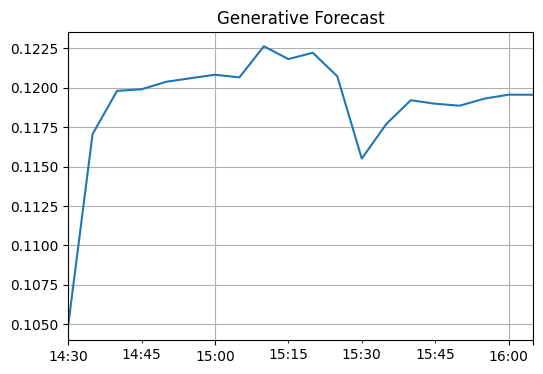

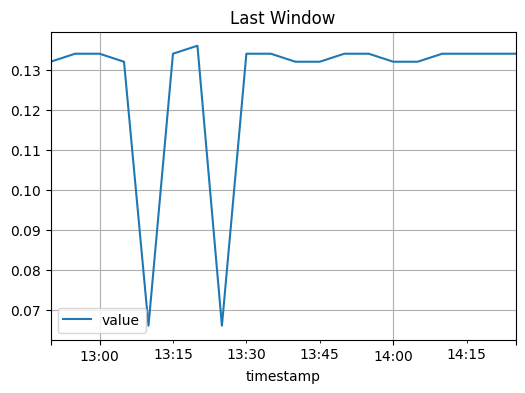

In [18]:
# select expert to generate
EXPERT_ID = 0
# features to forecast
SELECTED_FEATURES = 'value'
# should be min of original model
#REQUEST_WINDOW_SIZE = 200 * 2 # * 2 is added for convenience
REQUEST_WINDOW_SIZE = hyperparameters['window_size']
# temp dataframe for generative prediction input
df_temp = dataset_full.df_list[EXPERT_ID][-REQUEST_WINDOW_SIZE:]

if isinstance(df_temp, pd.Series):
    df_temp = df_temp.to_frame()

pred_generative, time_indexes_generative = generative_forecast(
    model=expert_trainer_dict[f'expert_{EXPERT_ID}']['model'], 
    data=df_temp.values,
    timestamps=df_temp.index,
    num_steps=hyperparameters['window_size'], 
    lag_window_size=hyperparameters['window_size'], 
    use_amp=hyperparameters['use_amp'], 
    device=expert_trainer_dict[f'expert_{EXPERT_ID}']['device']
)

pred_generative_array = np.array(pred_generative)

generative_results_dict = {}

# loop ove features
for feature_id, feature_key in enumerate(df_temp.columns):
    generative_results_dict[feature_key] = pred_generative_array[:, feature_id]
        
df_generative = pd.DataFrame(data=generative_results_dict, index=time_indexes_generative)

# REVERSE THE PREPROCESSING FOR ORIGINAL RANGE
df_generative[df_generative.columns] = dataset_full.scalers[EXPERT_ID].inverse_transform(df_generative[df_generative.columns])    

df_generative[SELECTED_FEATURES].plot(title='Generative Forecast')

# take a copy of the last window of actual data
df_last_window = dataset_full.named_df_list[f'expert_{EXPERT_ID}'][-hyperparameters['window_size']:].copy()

# REVERSE THE PREPROCESSING FOR ORIGINAL RANGE
df_last_window[df_last_window.columns] = dataset_full.scalers[EXPERT_ID].inverse_transform(df_last_window[df_last_window.columns])    

df_last_window.plot(title='Last Window')